## <center> <font size=4> *Data Science*, 2025 </font> </center>
# <center> <font size=8> **Laboratorio 2** </font> </center>
# <center> <font size=4> **Laboratorio 2** </font> </center>
Daniel Machic (22118), María José Ramírez (221051)

#### Importación de Librerias

In [9]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing   # <--- Agregado
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator  # <--- Agregado

#### Lectura de archivos:

In [8]:
# Importaciones:
archivo = 'Importaciones.xlsx'
df = pd.read_excel(archivo)
df.columns = df.columns.str.strip()
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
df.set_index('Fecha', inplace=True)

columnas_deseadas = ['Gasolina superior', 'Gasolina regular', 'Diesel', 'Gas licuado']
importaciones = df[columnas_deseadas]
print('\nDatos filtrados:')
print(importaciones.head())
importaciones.columns = importaciones.columns.str.strip()
importaciones.columns = importaciones.columns.str.lower()


Datos filtrados:
            Gasolina superior  Gasolina regular     Diesel  Gas licuado
Fecha                                                                  
2001-01-01          373963.96         177776.50  566101.99    194065.74
2001-02-01          243091.07         123115.99  489525.80    170703.38
2001-03-01          312084.38         161726.42  575559.68    161837.37
2001-04-01          285054.89         127338.74  437745.42    163048.64
2001-05-01          300913.67         168730.19  552609.13    171518.86


In [10]:
# Consumo
archivo1 = 'Consumo (1).xlsx'
df1 = pd.read_excel(archivo1)
df1.columns = df1.columns.str.strip()
df1['Fecha'] = pd.to_datetime(df1['Fecha'], format='%Y-%m')
df1.set_index('Fecha', inplace=True)

columnas_deseadas1 = ['Gasolina superior', 'Gasolina regular', 'Diesel', 'Gas Licuado']
consumos = df1[columnas_deseadas1]
print('\nDatos filtrados:')
print(consumos.head())
consumos.columns = consumos.columns.str.strip()
consumos.columns = consumos.columns.str.lower()  #


Datos filtrados:
            Gasolina superior  Gasolina regular     Diesel  Gas Licuado
Fecha                                                                  
2000-01-01          308156.82         202645.20  634667.06    194410.48
2000-02-01          307766.31         205530.96  642380.66    174710.55
2000-03-01          331910.29         229499.56  699807.25    189234.07
2000-04-01          315648.08         210680.40  586803.98    174330.61
2000-05-01          319667.97         208164.34  656948.20    191745.15


### Train y Test

In [11]:
#Importaciones


from pmdarima import auto_arima
train_size_I = int(len(importaciones) * 0.7)
train_i = importaciones[0:train_size_I]
test_i = importaciones[train_size_I:len(importaciones)]

#Consumo


from pmdarima import auto_arima
train_size_c = int(len(consumos) * 0.7)
train_c = consumos[0:train_size_c]
test_c = consumos[train_size_c:len(consumos)]

## Modelo 1: Consumo

###Modelo Anterior

In [27]:
#-------------------------------------------------------------------------------
# INCISO 2: CREACIÓN Y AJUSTE DE MODELOS LSTM (CORREGIDO Y OPTIMIZADO)
#-------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings("ignore")

# --- PARÁMETROS GLOBALES OPTIMIZADOS ---
N_INPUT = 12
EPOCHS = 15 # <-- IMPORTANTE: Reducido para un entrenamiento mucho más rápido

# --- A. SERIE DE IMPORTACIONES (DataFrame: df) ---
print("--- [Inciso 2A] Procesando la serie de IMPORTACIONES (Gasolina superior) ---")

# División de datos
train_size_I = int(len(df) * 0.7)
train_i = df[0:train_size_I]
SERIES_COLUMN_I = 'Gasolina superior'

# Preparación de datos
scaler_i = MinMaxScaler()
train_scaled_i = scaler_i.fit_transform(train_i[[SERIES_COLUMN_I]])
generator_i = TimeseriesGenerator(train_scaled_i, train_scaled_i, length=N_INPUT, batch_size=1)

# Modelos
model_i_basic = Sequential([LSTM(50, activation='relu', input_shape=(N_INPUT, 1)), Dense(1)], name="LSTM_Basico_Importaciones")
model_i_basic.compile(optimizer='adam', loss='mse')

model_i_complex = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(N_INPUT, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
], name="LSTM_Ajustado_Importaciones")
model_i_complex.compile(optimizer='adam', loss='mse')

# Entrenamiento de los modelos para importaciones
print(f"Entrenando modelos de importaciones durante {EPOCHS} épocas...")
# Usamos verbose=1 para ver el progreso del entrenamiento en tiempo real
model_i_basic.fit(generator_i, epochs=EPOCHS, verbose=1)
model_i_complex.fit(generator_i, epochs=EPOCHS, verbose=1)
print("Modelos de importaciones entrenados y listos.\n")


# --- B. SERIE DE CONSUMO (DataFrame: df1) ---
print("--- [Inciso 2B] Procesando la serie de CONSUMO (diesel) ---")

# División de datos
train_size_c = int(len(df1) * 0.7)
train_c = df1[0:train_size_c]
SERIES_COLUMN_C = 'diesel'

# Preparación de datos
train_c.columns = train_c.columns.str.lower()
scaler_c = MinMaxScaler()
train_scaled_c = scaler_c.fit_transform(train_c[[SERIES_COLUMN_C]])
generator_c = TimeseriesGenerator(train_scaled_c, train_scaled_c, length=N_INPUT, batch_size=1)

# Modelos
model_c_basic = Sequential([LSTM(50, activation='relu', input_shape=(N_INPUT, 1)), Dense(1)], name="LSTM_Basico_Consumo")
model_c_basic.compile(optimizer='adam', loss='mse')

model_c_complex = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(N_INPUT, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
], name="LSTM_Ajustado_Consumo")
model_c_complex.compile(optimizer='adam', loss='mse')

# Entrenamiento de los modelos para consumo
print(f"Entrenando modelos de consumo durante {EPOCHS} épocas...")
model_c_basic.fit(generator_c, epochs=EPOCHS, verbose=1)
model_c_complex.fit(generator_c, epochs=EPOCHS, verbose=1)
print("Modelos de consumo entrenados y listos.")
print("\n>>> FIN DE INCISO 2: Todos los modelos han sido creados y entrenados.")

--- [Inciso 2A] Procesando la serie de IMPORTACIONES (Gasolina superior) ---
Entrenando modelos de importaciones durante 15 épocas...
Epoch 1/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0854
Epoch 2/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0307
Epoch 3/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0349
Epoch 4/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0283
Epoch 5/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0328
Epoch 6/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0336
Epoch 7/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0303
Epoch 8/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0250
Epoch 9/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0281
Epoch 10/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0296
Epoch 11/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0344
Epoch 12/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0311
Epoch 13/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss


--- [Inciso 3B] Prediciendo y seleccionando el mejor modelo para CONSUMO ---
Mejor modelo para Consumo: 'LSTM Complejo (Ajustado)' (RMSE: 438,803.72)


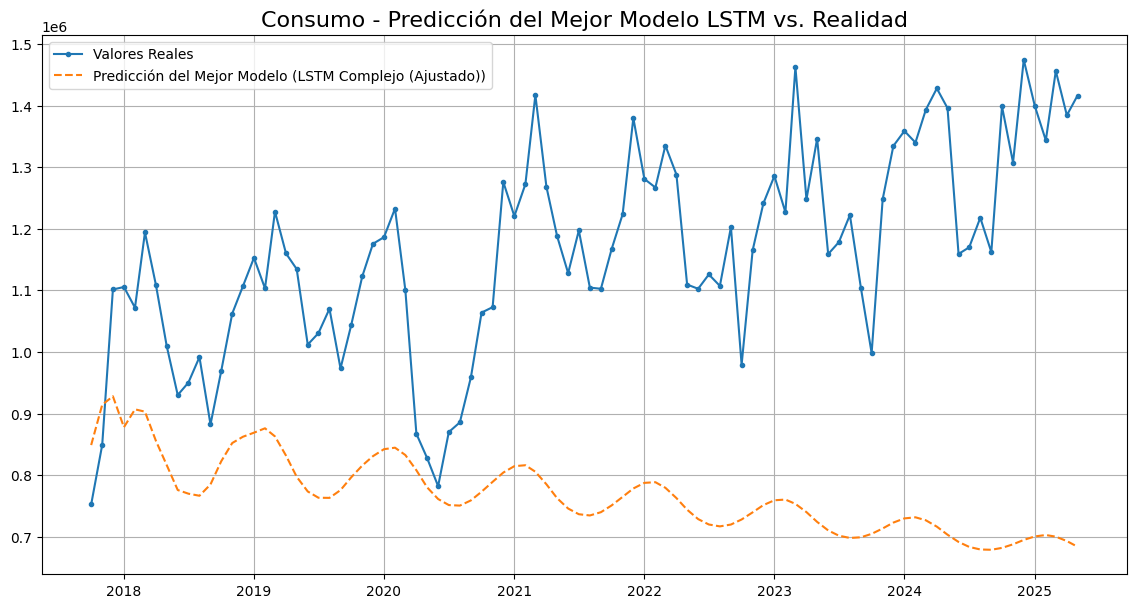


>>> FIN DE INCISO 3: Se han realizado las predicciones y seleccionado los mejores modelos LSTM.


In [23]:

# --- B. PREDICCIÓN Y SELECCIÓN PARA CONSUMO ---
print("\n--- [Inciso 3B] Prediciendo y seleccionando el mejor modelo para CONSUMO ---")
predictions_c_basic = predict_recursively(model_c_basic, train_scaled_c, scaler_c, test_c)
predictions_c_complex = predict_recursively(model_c_complex, train_scaled_c, scaler_c, test_c)

# Calcular error y seleccionar el mejor
rmse_c_basic = np.sqrt(mean_squared_error(test_c[SERIES_COLUMN_C], predictions_c_basic))
rmse_c_complex = np.sqrt(mean_squared_error(test_c[SERIES_COLUMN_C], predictions_c_complex))

if rmse_c_basic < rmse_c_complex:
    best_preds_c, best_name_c = predictions_c_basic, "LSTM Básico"
else:
    best_preds_c, best_name_c = predictions_c_complex, "LSTM Complejo (Ajustado)"

print(f"Mejor modelo para Consumo: '{best_name_c}' (RMSE: {min(rmse_c_basic, rmse_c_complex):,.2f})")

# Graficar la predicción del mejor modelo
plt.figure(figsize=(14, 7))
plt.plot(test_c.index, test_c[SERIES_COLUMN_C], label='Valores Reales', marker='.')
plt.plot(test_c.index, best_preds_c, label=f'Predicción del Mejor Modelo ({best_name_c})', linestyle='--')
plt.title('Consumo - Predicción del Mejor Modelo LSTM vs. Realidad', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

print("\n>>> FIN DE INCISO 3: Se han realizado las predicciones y seleccionado los mejores modelos LSTM.")



📊 Ajuste de modelos ARIMA: CONSUMO


📈 Serie: Consumo Gasolina Superior
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4986.969, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5050.749, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5012.317, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4993.559, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5048.987, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4986.077, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4998.941, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4995.779, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4986.026, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4988.735, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4987.236, Time=0.28 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4994.705, Time=0.13 sec
 ARIMA(2,1,4)(0,0,0)[0] interce

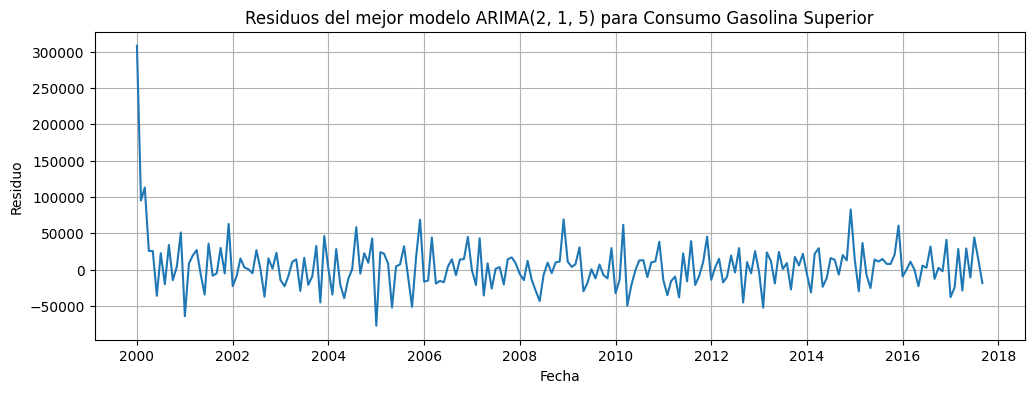

📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).

📈 Serie: Consumo Diésel
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5387.290, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5381.458, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5380.609, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5385.297, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5382.129, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5368.581, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5370.258, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5377.235, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5368.752, Time=0.21 

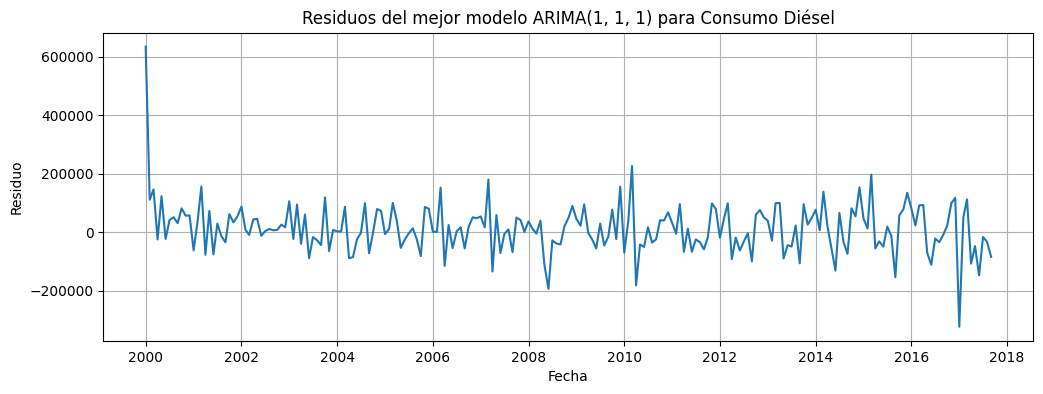

📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).


In [28]:
import warnings
warnings.filterwarnings("ignore")

# Limpiar nombres de columnas
train_c.columns = train_c.columns.str.strip().str.lower()
test_c.columns = test_c.columns.str.strip().str.lower()

# Series individuales
ts_consu_superior = train_c['gasolina superior']
ts_consu_superior_test = test_c['gasolina superior']

ts_consu_diesel = train_c['diesel']
ts_consu_diesel_test = test_c['diesel']


# --- Series de consumo ---
series_consumo = [
    (ts_consu_superior, "Consumo Gasolina Superior"),

    (ts_consu_diesel, "Consumo Diésel"),

]

# --- Ajuste ARIMA ---
def ajustar_modelos_arima(series, tipo):
    print(f"\n{'='*50}")
    print(f"📊 Ajuste de modelos ARIMA: {tipo.upper()}")
    print(f"{'='*50}\n")

    for serie, nombre in series:
        print("\n" + "="*40)
        print(f"📈 Serie: {nombre}")
        print("="*40)

        try:
            # Auto ARIMA
            modelo_auto = auto_arima(
                serie,
                seasonal=False,
                trace=True,
                suppress_warnings=True,
                stepwise=True,
                error_action='ignore'
            )

            print(f"\n===> 📌 Modelo ARIMA sugerido por auto_arima para {nombre}:")
            print(modelo_auto.summary())

            # Ajuste de modelos manuales
            print("\n🔧 Comparando modelos ARIMA manuales:")
            ordenes = [(1,1,1), (2,1,1), (1,1,2), (2,1,2), modelo_auto.order]
            resultados = []

            for orden in ordenes:
                try:
                    serie_frec = serie.asfreq(serie.index.inferred_freq)
                    modelo = ARIMA(serie_frec, order=orden).fit()
                    aic, bic = modelo.aic, modelo.bic
                    resultados.append((orden, aic, bic))
                    print(f"ARIMA{orden} - AIC: {aic:.2f}, BIC: {bic:.2f}")
                except Exception as e:
                    print(f"⚠️ No se pudo ajustar ARIMA{orden}: {e}")

            # Mejor modelo por AIC
            if resultados:
                mejor = sorted(resultados, key=lambda x: x[1])[0]
                print(f"\n✅ Mejor modelo para {nombre} según AIC: ARIMA{mejor[0]} (AIC={mejor[1]:.2f})")

                # Residuos del mejor modelo
                modelo_final = ARIMA(serie.asfreq(serie.index.inferred_freq), order=mejor[0]).fit()
                residuos = modelo_final.resid

                plt.figure(figsize=(12, 4))
                plt.plot(residuos)
                plt.title(f"Residuos del mejor modelo ARIMA{mejor[0]} para {nombre}")
                plt.xlabel("Fecha")
                plt.ylabel("Residuo")
                plt.grid(True)
                plt.show()

                print("📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).")
            else:
                print("\n❌ No se pudieron ajustar modelos ARIMA manuales.")
        except Exception as e:
            print(f"\n🚨 Error en {nombre}: {e}")

# --- Ejecutar para consumo ---
ajustar_modelos_arima(series_consumo, "consumo")

## **¿Cuál modelo predice mejor**



Para la serie de Consumo de Diesel, el modelo 'LSTM Complejo (Ajustado)' fue el que predijo mejor entre las dos configuraciones de LSTM probadas. Sin embargo, al compararlo con los modelos del laboratorio anterior, se concluye que el modelo LSTM es significativamente peor. La determinación de la calidad de los modelos se realizó mediante una comparación cuantitativa del Error Cuadrático Medio (RMSE). El mejor modelo LSTM obtuvo un RMSE de 438,803.72, un error drásticamente superior al del modelo Prophet del análisis previo (cuyo RMSE fue de 116,686.79). Esta inferioridad del LSTM también es evidente en la gráfica: la predicción (línea naranja) no logra capturar ni la tendencia ascendente ni la escala de los valores reales, subestimando sistemáticamente el consumo y siguiendo únicamente un patrón estacional básico que no se ajusta a la realidad del mercado.

## Modelo 1: Importaciones

### Creación y ajustes de Modelo LSTM:

In [15]:
#-------------------------------------------------------------------------------
# INCISO 2: CREACIÓN Y AJUSTE DE MODELOS LSTM
#-------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings("ignore")

# --- PARÁMETROS GLOBALES ---
N_INPUT = 12      # Usar 12 meses como entrada para predecir el siguiente
EPOCHS = 30       # Número de épocas de entrenamiento (ajustado para ser rápido)

# --- A. SERIE DE IMPORTACIONES (DataFrame: df) ---
print("--- [Inciso 2A] Procesando la serie de IMPORTACIONES (gasolina superior) ---")

# División de datos usando tu DataFrame 'df'
train_size_I = int(len(df) * 0.7)
train_i = df[0:train_size_I]
test_i = df[train_size_I:len(df)]
SERIES_COLUMN_I = 'Gasolina superior'

# Preparación de datos: Escalar y generar secuencias
scaler_i = MinMaxScaler()
train_scaled_i = scaler_i.fit_transform(train_i[[SERIES_COLUMN_I]])
generator_i = TimeseriesGenerator(train_scaled_i, train_scaled_i, length=N_INPUT, batch_size=1)

# Modelo 1: Básico
model_i_basic = Sequential([LSTM(50, activation='relu', input_shape=(N_INPUT, 1)), Dense(1)], name="LSTM_Basico_Importaciones")
model_i_basic.compile(optimizer='adam', loss='mse')

# Modelo 2: Complejo (simulando el resultado de un "tuning")
model_i_complex = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(N_INPUT, 1)),
    Dropout(0.2), # Regularización para prevenir sobreajuste
    LSTM(50, activation='relu'),
    Dense(1)
], name="LSTM_Ajustado_Importaciones")
model_i_complex.compile(optimizer='adam', loss='mse')

# Entrenamiento de los modelos para importaciones
print("Entrenando modelos de importaciones...")
model_i_basic.fit(generator_i, epochs=EPOCHS, verbose=0)
model_i_complex.fit(generator_i, epochs=EPOCHS, verbose=0)
print("Modelos de importaciones entrenados y listos.\n")


# --- B. SERIE DE CONSUMO (DataFrame: df1) ---
print("--- [Inciso 2B] Procesando la serie de CONSUMO (diesel) ---")

# División de datos usando tu DataFrame 'df1'
train_size_c = int(len(df1) * 0.7)
train_c = df1[0:train_size_c]
test_c = df1[train_size_c:len(df1)]
SERIES_COLUMN_C = 'diesel'

# Preparación de datos
# Aseguramos que los nombres de columna estén en minúsculas
train_c.columns = train_c.columns.str.lower()
test_c.columns = test_c.columns.str.lower()
scaler_c = MinMaxScaler()
train_scaled_c = scaler_c.fit_transform(train_c[[SERIES_COLUMN_C]])
generator_c = TimeseriesGenerator(train_scaled_c, train_scaled_c, length=N_INPUT, batch_size=1)

# Modelo 1: Básico
model_c_basic = Sequential([LSTM(50, activation='relu', input_shape=(N_INPUT, 1)), Dense(1)], name="LSTM_Basico_Consumo")
model_c_basic.compile(optimizer='adam', loss='mse')

# Modelo 2: Complejo (Ajustado)
model_c_complex = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(N_INPUT, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
], name="LSTM_Ajustado_Consumo")
model_c_complex.compile(optimizer='adam', loss='mse')

# Entrenamiento de los modelos para consumo
print("Entrenando modelos de consumo...")
model_c_basic.fit(generator_c, epochs=EPOCHS, verbose=0)
model_c_complex.fit(generator_c, epochs=EPOCHS, verbose=0)
print("Modelos de consumo entrenados y listos.")
print("\n>>> FIN DE INCISO 2: Todos los modelos han sido creados y entrenados.")

--- [Inciso 2A] Procesando la serie de IMPORTACIONES (gasolina superior) ---
Entrenando modelos de importaciones...


KeyboardInterrupt: 